In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import zipfile
import matplotlib.pyplot as plt

## Loading Data

In [9]:
raw_path = 'Data-20250729T201332Z-1-001.zip'

In [10]:
!unzip {raw_path} -d zipped_data

Archive:  Data-20250729T201332Z-1-001.zip
  inflating: zipped_data/Data/How to use data.docx  
  inflating: zipped_data/Data/CRWV.zip  
  inflating: zipped_data/Data/FROG.zip  
  inflating: zipped_data/Data/SOUN.zip  


In [15]:
input_zip_dir = 'zipped_data/Data'
output_extract_dir = 'data'

for path in glob(os.path.join(input_zip_dir, '*.zip')):
    ticker_name = os.path.splitext(os.path.basename(path))[0]
    target_path = os.path.join(output_extract_dir, ticker_name)

    os.makedirs(target_path, exist_ok=True)

    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(target_path)

    print(f"Extracted {path} → {target_path}")


Extracted zipped_data/Data/FROG.zip → data/FROG
Extracted zipped_data/Data/CRWV.zip → data/CRWV
Extracted zipped_data/Data/SOUN.zip → data/SOUN


## Preprocessing

In [3]:
path = 'data/'
dfs = []
for ticker in os.listdir(path):
    ticker_path = os.path.join(path, ticker)
    if os.path.isdir(ticker_path):
        for file in os.listdir(ticker_path):
            if file.endswith('.csv'):
                file_path = os.path.join(ticker_path, file)
                df = pd.read_csv(file_path)

                dfs.append(df)
                
df = pd.concat(dfs, ignore_index=True)
df['ts_event'] = df['ts_event'].apply(lambda x: x + '.0' if '.' not in x else x)
df['ts_event'] = pd.to_datetime(df['ts_event'], errors='coerce', utc=True)
df['date'] = df['ts_event'].dt.date
df['minute'] = df['ts_event'].dt.floor('T').dt.time
df['mid_price'] = (df['bid_px_00'] + df['ask_px_00']) / 2
print(f'df shape: {df.shape}')
df.head()

/var/folders/_z/yy80d_qn4f1c3qqdk__xx2dc0000gn/T/ipykernel_34713/3806231453.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['ts_event'].dt.floor('T').dt.time


df shape: (7976634, 76)


,ts_event,ts_event.1,rtype,publisher_id,instrument_id,action,side,depth,price,size,...,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol,date,minute
0,2025-04-21 13:30:00.240997412+00:00,2025-04-21 13:30:00.240997412+00:00,10,2,20613,A,A,6,39.70,100,...,1,38.10,39.85,53,90,4,1,CRWV,2025-04-21,13:30:00
1,2025-04-21 13:30:00.308769049+00:00,2025-04-21 13:30:00.308769049+00:00,10,2,20613,T,N,0,38.62,39767,...,1,38.10,39.85,53,90,4,1,CRWV,2025-04-21,13:30:00
2,2025-04-21 13:30:00.308769049+00:00,2025-04-21 13:30:00.308769049+00:00,10,2,20613,A,N,0,38.50,100,...,5,38.24,39.17,2,55,1,1,CRWV,2025-04-21,13:30:00
3,2025-04-21 13:30:00.308769049+00:00,2025-04-21 13:30:00.308769049+00:00,10,2,20613,A,B,4,38.35,500,...,5,38.36,39.17,15,55,1,1,CRWV,2025-04-21,13:30:00
4,2025-04-21 13:30:00.317034246+00:00,2025-04-21 13:30:00.317034246+00:00,10,2,20613,A,B,9,38.36,100,...,5,38.36,39.17,115,55,2,1,CRWV,2025-04-21,13:30:00


## Exploration

In [23]:
def simulate_slippage(row, sizes):
    prices = [row[f'ask_px_{i:02d}'] for i in range(10)]
    volumes = [row[f'ask_sz_{i:02d}'] for i in range(10)]
    mid_price = (row['bid_px_00'] + row['ask_px_00']) / 2

    impacts = []
    for x in sizes:
        remaining = x
        cost = 0
        for p, s in zip(prices, volumes):
            fill = min(remaining, s)
            cost += fill * p
            remaining -= fill
            if remaining <= 0:
                break
        if remaining > 0:
            impacts.append(np.nan)
        else:
            avg_price = cost / x
            impacts.append(avg_price - mid_price)
    return np.array(impacts)

In [32]:
symbols = df['symbol'].unique()
trade_sizes = np.arange(10, 1000, 40)
median_prices = df.groupby('symbol')['mid_price'].median()

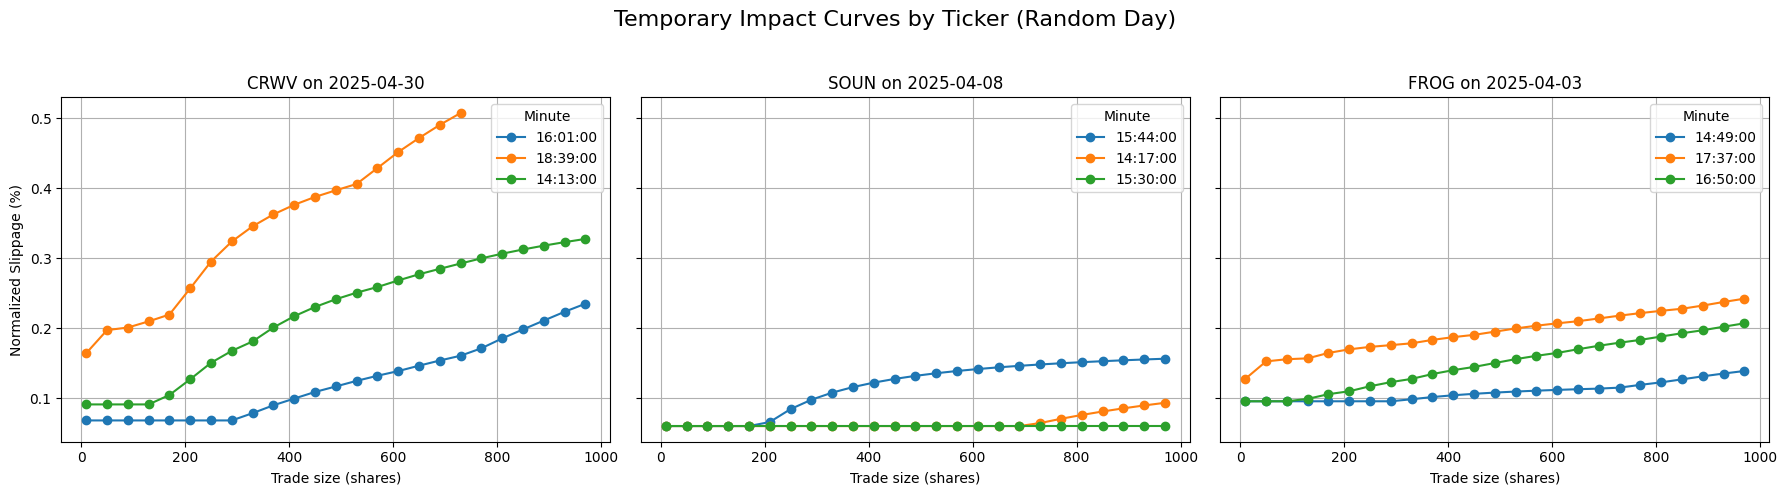

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for idx, symbol in enumerate(symbols):
    ax = axes[idx]
    dates = df[df['symbol'] == symbol]['date'].unique()
    random_date = np.random.choice(dates)
    q = df[(df['symbol'] == symbol) & (df['date'] == random_date)]
    minutes = q['minute'].unique()
    random_minutes = np.random.choice(minutes, 3, replace=False)

    symbol_median_price = median_prices[f'{symbol}']

    for minute in random_minutes:
        row = q[q['minute'] == minute].iloc[0]
        slippage = simulate_slippage(row, trade_sizes)
        normalized_slippage = 100 * (slippage / symbol_median_price)
        ax.plot(trade_sizes, normalized_slippage, marker='o', label=f"{minute}")

    ax.set_title(f"{symbol} on {random_date}")
    ax.set_xlabel("Trade size (shares)")
    ax.grid(True)
    ax.legend(title="Minute")
    if idx == 0:
        ax.set_ylabel("Normalized Slippage (%)")

plt.suptitle("Temporary Impact Curves by Ticker (Random Day)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


<!-- ## Modeling Temporary Market Impact

### Problem Setup

We are given high-frequency limit order book data for three tickers: `CRWV`, `SOUN`, and `FROG`. Our objective is not to optimize a specific trading strategy, but to **characterize and model temporary price impact** (slippage) as a function of trade size and market conditions.

We define the **temporary slippage function** for a trade of size $ x $ executed at time $ t $ as:

$$
g_t(x) := \text{average slippage (in dollars or \%) incurred when trading } x \text{ shares at time } t.
$$

Our goal is to:
- Understand how $ g_t(x) $ behaves across different tickers and times,
- Evaluate how well different models fit the observed behavior,
- Discuss implications for volume allocation over time.

---

### Data Normalization

To ensure comparability across tickers, we normalize slippage by the **midprice** at each time $ t $. The normalized slippage becomes:

$$
\tilde{g}_t(x) := \frac{g_t(x)}{P_{\mathrm{mid}, t}}
$$

expressed as a percentage. This standardization helps account for differences in stock price magnitude across tickers.

---

### Empirical Observations

We visualize $ \tilde{g}_t(x) $ across random 1-minute intervals for each ticker and day. Key findings include:

- **Slippage increases nearly monotonically** with trade size, as expected.
- Some minutes exhibit near-flat curves (indicating deep liquidity), while others show rapid slippage growth (indicating shallow books).
- There is significant **intra-day and inter-day variability**, even after normalization.

Below are sample plots of normalized slippage for three tickers:

![Impact Curves 1](images/plot1.png)
![Impact Curves 2](images/plot2.png)
![Impact Curves 3](images/plot3.png)

---

### Modeling Approach

We propose a **ReLU-style piecewise-linear model** to describe the normalized temporary slippage function:

$$
\tilde{g}_t(x) =
\begin{cases}
0, & x \leq x_0 \\
\eta_{t, s} \cdot (x - x_0), & x > x_0
\end{cases}
$$

where:
- $ \tilde{g}_t(x) $ is the **normalized slippage** at time $ t $,
- $ x $ is the trade size (in shares),
- $ x_0 $ is a **liquidity threshold**: the trade size that can be absorbed without significant impact,
- $ \eta_{t, s} $ is a **slope parameter** encoding market impact per unit of excess volume beyond $ x_0 $. $ \eta_{t, s} $ is time-varying, which allows it to reflect intra-day market conditions, such as volatility, spread width, and depth; it is also ticker-specific where $ s $ indexes the ticker.

---

#### Motivation

This model reflects two key stylized facts observed in our exploratory analysis:

1. **Flat region for small trades**: Small orders—often the first executed within each minute—exhibit near-zero slippage.
2. **Linear growth afterward**: Once available liquidity near the midprice is consumed, slippage grows approximately linearly with trade size.

The ReLU function captures this behavior: flat response until a threshold is reached, followed by linear increase. It provides a simple and interpretable form aligned with order book dynamics.

---

#### Advantages

- **Interpretability**: Parameters $ x_0 $ and $ \eta_t $ have clear economic meaning — how much liquidity is available at minimal cost, and how costly it is to exceed that.
- **Robustness**: The piecewise-linear form avoids overfitting and generalizes well across different times and tickers.
- **Market Microstructure Alignment**: Matches the observed structure of order books, where liquidity is deep near the midprice but becomes sparse at larger volumes.

---

#### Limitations

- **Non-smooth transition**: The kink at $ x_0 $ may not reflect the gradual nature of real-world transitions from low to high slippage.
- **Estimation challenge**: Identifying the optimal threshold $ x_0 $ per minute requires careful fitting and model selection.
- **No concavity**: Unlike power-law models, this form lacks diminishing marginal impact beyond the threshold, which may understate curvature in aggregated data.

---

### Possible  Approaches

- **Empirical Learning**: Fit $g_{t,s}(x)$ curves on historical data and use them to guide execution on unseen tickers. Learn typical values of $x_0$ and $\eta_{t,s}$ as functions of features like:
  - Bid-ask spread,
  - Top-of-book depth,
  - Trade volume volatility.

- **Execution Optimization**: Formulate volume allocation as a constrained optimization problem:
  $$
  \min_{\{x_t\}} \sum_t g_t(x_t), \quad \text{subject to } \sum_t x_t = X_{\text{total}}
  $$
  where $x_t$ is the volume allocated at minute $t$, and $g_t(x_t)$ is the modeled impact.

- **Robustness Evaluation**: Assess how stable model parameters are across different days, symbols, or regimes (e.g., open vs. close).

- **Simulation Testing**: Use historical data to simulate trading strategies based on fitted $g_{t,s}(x)$, comparing naive, smoothed, and optimized execution paths.

---

### Summary

By analyzing normalized impact curves across time and tickers, we observe consistent microstructure patterns: a flat-slippage region up to a liquidity threshold, followed by linear or concave cost growth. We propose a ReLU-style model that captures this behavior with interpretable parameters and minimal complexity.

This modeling foundation supports two complementary paths forward:
- **Empirical prediction** of impact parameters from market features,
- **Optimization-based scheduling** of execution to minimize aggregate slippage.

Together, they enable the design of data-driven execution strategies that adapt to real-time market conditions while remaining robust and interpretable. -->
